# Maternal Health Risk

## Task A. Load Dataset

### Accessing the dataset

In [ ]:
import pandas as pd
# Accessing the dataset
data_path = "MaternalHealthRisk.csv"
df = pd.read_csv(data_path)

# Dataset shape and column names
print('Shape:', df.shape)
print('Columns:', df.columns.tolist())

# First 5 rows
df.head()

Shape: (1014, 7)
Columns: ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate', 'RiskLevel']


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


## Task B. Exploratory Data Analysis

### Data types

In [2]:
print(df.dtypes)

Age              int64
SystolicBP       int64
DiastolicBP      int64
BS             float64
BodyTemp       float64
HeartRate        int64
RiskLevel       object
dtype: object


### Missing values

In [3]:
print(df.isnull().sum())

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64


### Statistical summary data

In [4]:
display(df.describe())

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


### Correlation matrix

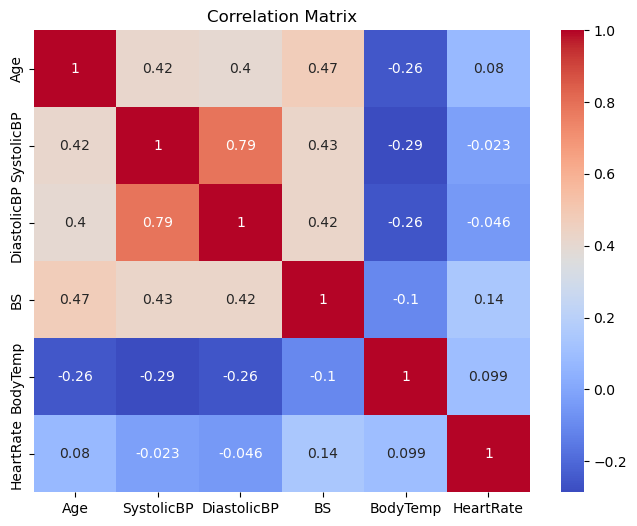

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

### Histograms for numeric columns

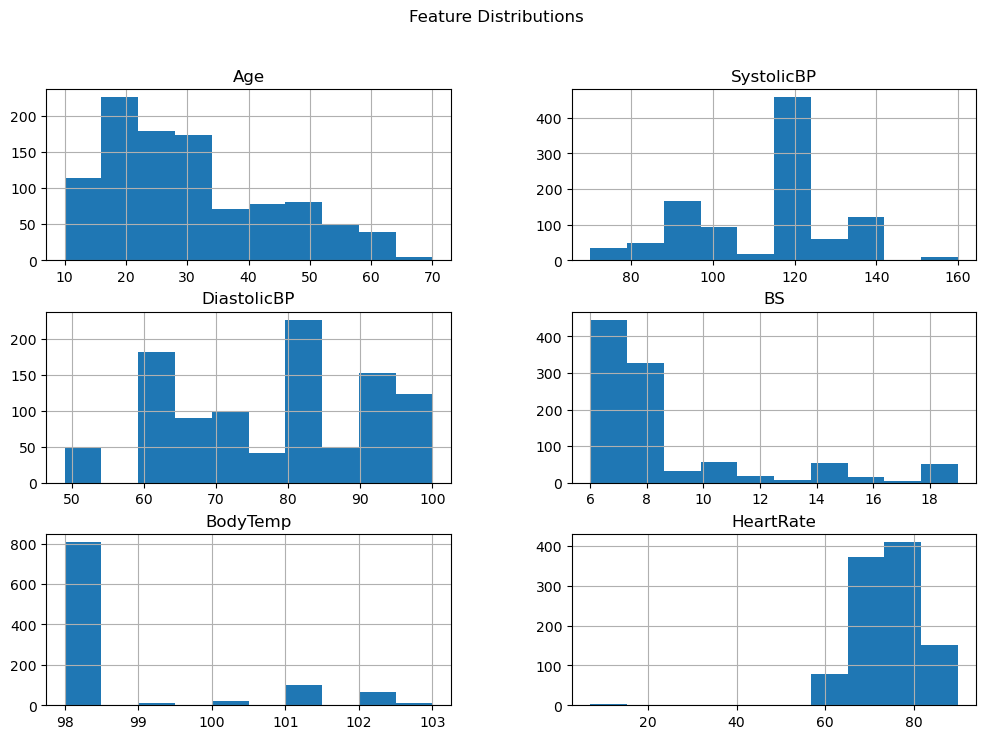

In [6]:
df.hist(figsize=(12,8))
plt.suptitle("Feature Distributions")
plt.show()

### Boxplots

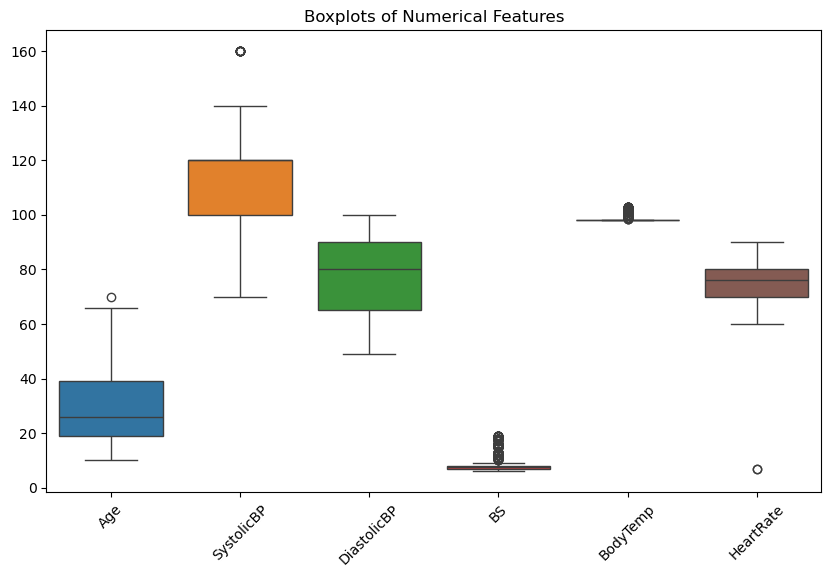

In [7]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df)
plt.title("Boxplots of Numerical Features")
plt.xticks(rotation=45)
plt.show()

## Task C. Data Preparation

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Checking for duplicates
print("Duplicates:", df.duplicated().sum())
# Removing duplicates
df = df.drop_duplicates()

# Tackling the missing values (dataset has none, but just in case)
df = df.fillna(df.median(numeric_only=True))

# Outlier handling (IQR method – light filtering)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower, upper)

# Encoding the target (low risk to 0, mid risk to 1, high risk to 2)
if df['RiskLevel'].dtype == object:
    df['RiskLevel'] = df['RiskLevel'].map({'low risk':0, 'mid risk':1, 'high risk':2})

# Defining features and target
X = df.drop('RiskLevel', axis=1)
y = df['RiskLevel']

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Duplicates: 562


## Task D. Models Training

### Imports

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    balanced_accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
)

import numpy as np
import pickle

### Hyperparameter Tuning (GridSearchCV)

In [10]:
# Reproducible CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#### Logistic Regression

In [11]:
lr_grid = {'C': [0.1, 1, 10]}

lr_gs = GridSearchCV(
    LogisticRegression(max_iter=500, random_state=42),
    lr_grid,
    cv=cv,
    scoring='f1_weighted',
    n_jobs=-1
)
lr_gs.fit(X_train_scaled, y_train)
lr_best = lr_gs.best_estimator_
y_lr = lr_best.predict(X_test_scaled)

#### K-Nearest Neighbours

In [12]:
knn_grid = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}

knn_gs = GridSearchCV(
    KNeighborsClassifier(),
    knn_grid,
    cv=cv,
    scoring='f1_weighted',
    n_jobs=-1
)
knn_gs.fit(X_train_scaled, y_train)
knn_best = knn_gs.best_estimator_
y_knn = knn_best.predict(X_test_scaled)

#### Random Forest

In [25]:
rf_grid = {'n_estimators': [50, 100], 'max_depth': [5, 10, None]}

rf_gs = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_grid,
    cv=cv,
    scoring='f1_weighted',
    n_jobs=-1
)
rf_gs.fit(X_train_scaled, y_train)
rf_best = rf_gs.best_estimator_
y_rf = rf_best.predict(X_test_scaled)

### Matrics computing

In [26]:
def compute_metrics(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'BalancedAccuracy': balanced_accuracy_score(y_true, y_pred),
        'Precision_w': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'Recall_w': recall_score(y_true, y_pred, average='weighted'),
        'F1_w': f1_score(y_true, y_pred, average='weighted')
    }

# Computing metrics for the tuned models
lr_metrics = compute_metrics(y_test, y_lr)
knn_metrics = compute_metrics(y_test, y_knn)
rf_metrics = compute_metrics(y_test, y_rf)

### Comparison table

In [15]:
comparison = pd.DataFrame([
    {'Model': 'Logistic Regression',
     'Accuracy': lr_metrics['Accuracy'],
     'Precision (weighted)': lr_metrics['Precision_w'],
     'Recall (weighted)': lr_metrics['Recall_w'],
     'F1 (weighted)': lr_metrics['F1_w']},
    {'Model': 'K-Nearest Neighbors',
     'Accuracy': knn_metrics['Accuracy'],
     'Precision (weighted)': knn_metrics['Precision_w'],
     'Recall (weighted)': knn_metrics['Recall_w'],
     'F1 (weighted)': knn_metrics['F1_w']},
    {'Model': 'Random Forest',
     'Accuracy': rf_metrics['Accuracy'],
     'Precision (weighted)': rf_metrics['Precision_w'],
     'Recall (weighted)': rf_metrics['Recall_w'],
     'F1 (weighted)': rf_metrics['F1_w']}
])

# Rounding numbers for display
display(comparison.round(3))

,Model,Accuracy,Precision (weighted),Recall (weighted),F1 (weighted)
0,Logistic Regression,0.670,0.676,0.670,0.605
1,K-Nearest Neighbors,0.681,0.656,0.681,0.651
2,Random Forest,0.747,0.805,0.747,0.690


### Final model selection

In [24]:
f1_values = comparison['F1 (weighted)'].values
best_idx = int(np.argmax(f1_values))
final_row = comparison.iloc[best_idx]
final_model_name = final_row['Model']

if final_model_name == 'Logistic Regression':
    final_model = lr_best
    y_final = y_lr
elif final_model_name == 'K-Nearest Neighbors':
    final_model = knn_best
    y_final = y_knn
else:
    final_model = rf_best
    y_final = y_rf

print("Final model selected based on highest F1 (weighted):", final_model_name)

Final model selected based on highest F1 (weighted): Random Forest


## Task E. Model Evaluation

### Evaluation for final model

In [28]:
print("Classification report for final model:\n")
print(classification_report(y_test, y_final, zero_division=0))

Classification report for final model:

              precision    recall  f1-score   support

           0       0.71      1.00      0.83        47
           1       1.00      0.14      0.25        21
           2       0.82      0.78      0.80        23

    accuracy                           0.75        91
   macro avg       0.84      0.64      0.63        91
weighted avg       0.81      0.75      0.69        91



### Plot confusion matrix

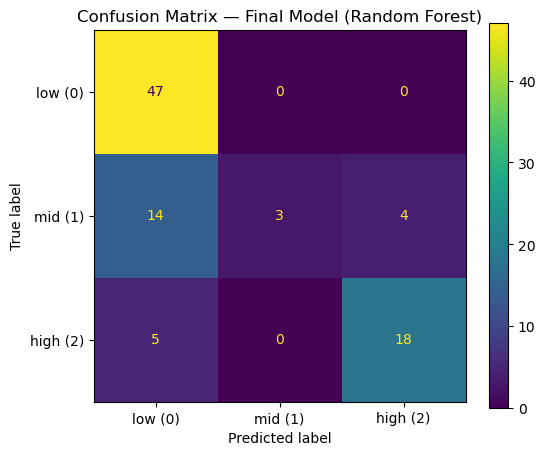

In [22]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['low (0)', 'mid (1)', 'high (2)'])
fig, ax = plt.subplots(figsize=(6,5))
disp.plot(values_format='d', ax=ax)
plt.title(f"Confusion Matrix — Final Model ({final_model_name})")
plt.show()

### Summary

In [27]:
print("Best hyperparameters (tuned models):")
print("Logistic Regression:", lr_gs.best_params_)
print("KNN:", knn_gs.best_params_)
print("Random Forest:", rf_gs.best_params_)

Best hyperparameters (tuned models):
Logistic Regression: {'C': 1}
KNN: {'n_neighbors': 3, 'weights': 'uniform'}
Random Forest: {'max_depth': 5, 'n_estimators': 50}


### Saving the final model and scaler

In [21]:
# Save the final tuned model
pickle.dump(final_model, open("final_model.pkl", "wb"))
# Save the StandardScaler fitted earlier
pickle.dump(scaler, open("standard_scaler.pkl", "wb"))